In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

from run_predictions import detect_red_light_mf_v0, detect_red_light_mf
from eval_detector import compute_iou, compute_counts

In [2]:
def read_im(fname, data_path='../RedLights2011_Medium'):
    # read image using PIL:
    I = Image.open(os.path.join(data_path,fname))
    # convert to numpy array:
    return np.asarray(I)


def plot_with_bounding_boxes(I, bboxes, ax=None, l_width=1):
    ''' Helper function that plots image I with bounding boxes'''
    if ax is None:
        ax = plt.subplot(111)
    if isinstance(l_width, (int, float)):
        l_width = [l_width] * len(bboxes)
    
    ax.imshow(I)
    
    for i, bbox in enumerate(bboxes):
        # Create a Rectangle patch
        y1, x1, y2, x2 = bbox
        anchor = (x1, y1)
        width = (x2 - x1)
        height = (y2 - y1)
        rect = patches.Rectangle(anchor, width, height, 
                    linewidth=l_width[i], edgecolor='g', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
    return ax

Bounding boxes:  [[172, 596, 244, 632], [227, 421, 401, 508], [22, 318, 88, 351], [15, 131, 75, 161], [150, 452, 318, 536], [0, 580, 162, 640], [244, 566, 364, 626], [298, 108, 442, 180], [91, 479, 145, 506], [85, 551, 193, 605], [337, 49, 373, 67], [316, 198, 480, 282]]


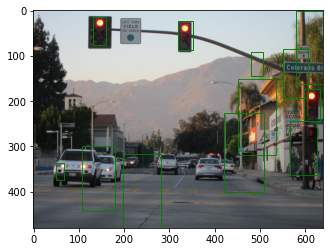

In [3]:
fname = 'RL-010.jpg'
bboxes0 = detect_red_light_mf(fname)
scores = [bbox[4] for bbox in bboxes0]
bboxes = [bbox[:4] for bbox in bboxes0]
print('Bounding boxes: ', bboxes)
plot_with_bounding_boxes(read_im(fname), bboxes, l_width=scores);

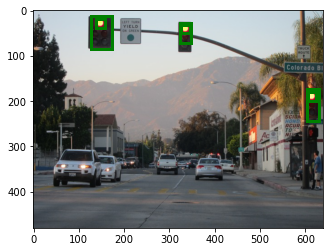

In [4]:
fname = 'RL-010.jpg'
ann_path = './hw02_annotations'
with open(os.path.join(ann_path, 'annotations.json'), 'r') as f:
    anns = json.load(f)
    
plot_with_bounding_boxes(read_im(fname), anns[fname], l_width=3);

[31, 326, 50, 346] [22, 318, 88, 351]


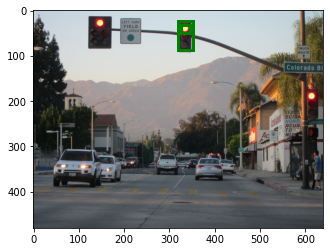

In [5]:
i, j = (3, 2)
b = bboxes
a = anns[fname]
plot_with_bounding_boxes(read_im(fname), [a[i], b[j]], l_width=3);
compute_iou(a[i], b[j])

### Visualize / PR Curves

In [6]:
def make_pr_curve(preds, gts, iou_thresh=0.5, confidence_thrs=None):
    tp = np.zeros(len(confidence_thrs))
    fp = np.zeros(len(confidence_thrs))
    fn = np.zeros(len(confidence_thrs))
    for i, conf_thr in enumerate(confidence_thrs):
        tp[i], fp[i], fn[i] = compute_counts(preds, gts,
                iou_thr=iou_thresh, conf_thr=conf_thr)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    return prec, recall

In [7]:
# set a path for predictions and annotations:
preds_path = './hw02_preds'
gts_path = './hw02_annotations'

# load splits:
split_path = './hw02_splits'
file_names_train = np.load(os.path.join(split_path,'file_names_train.npy'))
file_names_test = np.load(os.path.join(split_path,'file_names_test.npy'))

# Set this parameter to True when you're done with algorithm development:
done_tweaking = True

'''
Load training data.
'''
with open(os.path.join(preds_path,'preds_train.json'),'r') as f:
    preds_train = json.load(f)

with open(os.path.join(gts_path, 'annotations_train.json'),'r') as f:
    gts_train = json.load(f)


if done_tweaking:

    '''
    Load test data.
    '''

    with open(os.path.join(preds_path,'preds_test.json'),'r') as f:
        preds_test = json.load(f)

    with open(os.path.join(gts_path, 'annotations_test.json'),'r') as f:
        gts_test = json.load(f)


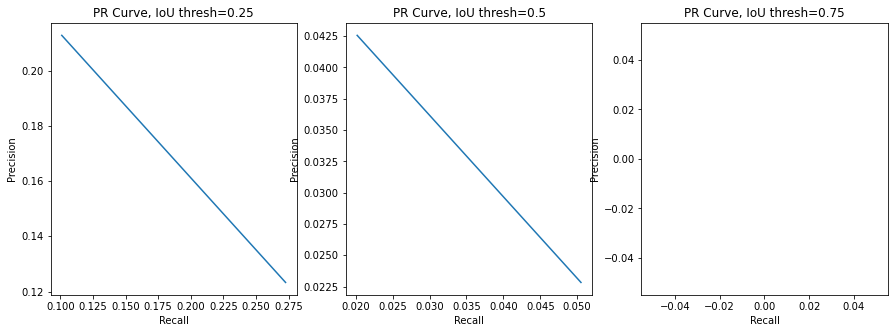

In [9]:
# For a fixed IoU threshold, vary the confidence thresholds.
# The code below gives an example on the training set for one IoU threshold.

scores = sum([[bbox[4] for bbox in v] for k,v in preds_train.items()], [])
# using (ascending) list of confidence scores as thresholds
confidence_thrs = np.sort(np.array(scores))


# Plot training set PR curves

if done_tweaking:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    for ax, thresh in zip(axes, [0.25, 0.5, 0.75]):
        prec, recall = make_pr_curve(preds_test, gts_test, thresh, confidence_thrs)
        ax.plot(recall, prec)
        ax.set_title(f'PR Curve, IoU thresh={thresh}')
        ax.set_xlabel('Recall'); ax.set_ylabel('Precision')

In [ ]:
prec, recall = make_pr_curve(0.01, confidence_thrs)
plt.plot(recall, prec)
plt.title(f'PR Curve, IoU thresh={thresh}')
plt.xlabel('Recall'); plt.ylabel('Precision');

In [ ]:
np.unique(recall)

In [ ]:
np.unique(prec)

This clearly works much better at identifying stop lights!

# SCRIPT

In [ ]:
#!python3 run_predictions.py

## Visualizing script results

In [ ]:
preds_path = 'hw01_preds/preds.json'
with open(preds_path, 'r') as f:
    preds = json.load(f)

In [ ]:
good_fnames = ['RL-010.jpg', 'RL-007.jpg']
n = len(good_fnames)
fig, axes = plt.subplots(n, 1, figsize=(6, 6 * n))
for i, (fname, ax) in enumerate(zip(good_fnames, axes)):
    bboxes = preds[fname]
    plot_with_bounding_boxes(read_im(fname), bboxes, l_width=3, ax=ax)
    ax.set_title(f'Good bounding boxes for {fname}')
    # Save just the portion around the second axis's boundaries
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'good_{i+1}.png', bbox_inches=extent.expanded(1.2, 1.2))

In [ ]:
bad_fnames = ['RL-001.jpg', 'RL-004.jpg', 'RL-043.jpg']
n = len(bad_fnames)
fig, axes = plt.subplots(n, 1, figsize=(6, 6 * n))
for i, (fname, ax) in enumerate(zip(bad_fnames, axes)):
    bboxes = preds[fname]
    plot_with_bounding_boxes(read_im(fname), bboxes, l_width=3, ax=ax)
    ax.set_title(f'Bad bounding boxes for {fname}')
    # Save just the portion around the second axis's boundaries
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'bad_{i+1}.png', bbox_inches=extent.expanded(1.2, 1.2))